## Ski Rental with Movie Lens
This notebook trains predictors for whether a user will watch more than b movies in the next month. 
We use these raw and calibrated predictors to compare the results of the ski-rental algorithms we propose in our paper.

In [43]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
# features
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve


#calibration library
from crepes import WrapRegressor

# metrics
from sklearn.metrics import roc_auc_score
from sklearn import tree

import models as md
import utils as ut
import calibrator as cal
import skirental as sr

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Section 0: Loading Data

Text(0.5, 1.0, 'Distribution of target values for Bike dataset')

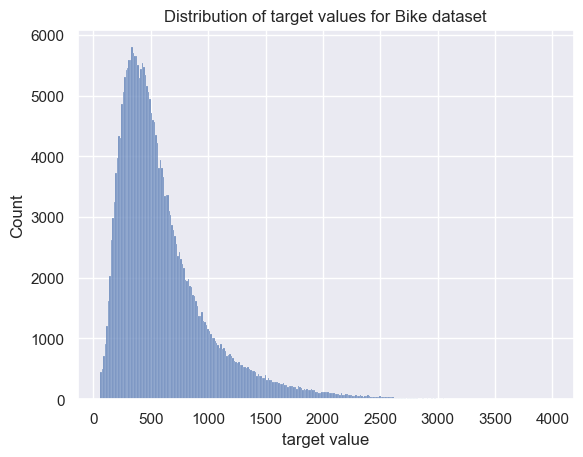

In [119]:
DATASET = 'Bike'

if DATASET == 'Movies': 
    movie_df = pd.read_csv('clean_data/movie_lens100k_monthly.csv')
    y = movie_df['movies_this_month'].values
    # Transform both feature sets
    X_clf = movie_df[['age', 'gender', 'occupation', 'zip', 'movies_watched']]
    X_reg = movie_df[['age', 'gender', 'movies_watched']]

    # Create separate DictVectorizers for each feature set
    vec_clf = DictVectorizer()
    vec_reg = DictVectorizer()

    X_post_clf = vec_clf.fit_transform(X_clf.to_dict('records')).toarray()
    X_post_reg = vec_reg.fit_transform(X_reg.to_dict('records')).toarray()
elif DATASET == 'Bike': 
    n=10000
    bike_df = pd.read_csv('clean_data/citibike-jan2015.csv').dropna() #.sample(n) 
    joint_df = bike_df #[bike_df['tripduration']<1000]
    # positive = bike_df[bike_df['tripduration'] >= b].sample(int(n/2))
    # negative = bike_df[bike_df['tripduration'] < b].sample(int(n/2))
    # joint_df = pd.concat([positive, negative])

    X = joint_df[['birth year', 'gender', 'usertype', 'start latitude rounded', 'start longitude rounded', 'starthour']]
    y = joint_df['tripduration'].values

    # Create separate DictVectorizers for each feature set
    vec_clf = DictVectorizer()
    vec_reg = DictVectorizer()

    X_post_clf = vec_clf.fit_transform(X.to_dict('records')).toarray()
    X_post_reg = vec_reg.fit_transform(X.to_dict('records')).toarray()

sns.histplot(y)
plt.xlabel('target value')
plt.title(f'Distribution of target values for {DATASET} dataset')

### Section 1: Training & Calibrating Predictors
This section is to verify the achievable accuracy / perforamnce of predictors on this dataset

In [24]:
# training calibrated regression model: 
i=0
X_train, X_test, y_train, y_test = train_test_split(
    X_post_reg, y, test_size=0.20, random_state=i)

X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.20, random_state=i)

print(f"size train: {len(X_train)}, valid: {len(X_valid)} test: {len(X_test)} ")

for clf in md.reg_dict: 
    start_time = time.time()
    model = Pipeline(
                [
                    ("scalar", StandardScaler()),
                    ("reg", md.reg_dict[clf]())
                ]
            )
    model.fit(X_train, y_train)
    print(f"{clf}: {model.score(X_test, y_test)}")
    rf = WrapRegressor(model)
    rf.fit(X_train, y_train)
    rf.calibrate(X_valid, y_valid)
    for conf in [0.7, 0.8, 0.9, 0.95]: 
        conf_interval = rf.predict_int(X_test, confidence=conf)
        print(f'conf: {conf} interval size: {(conf_interval[:, 1] - conf_interval[:, 0]).mean()}')
    end_time = time.time()
    execution_time = end_time - start_time 
    print(f"Function took {execution_time} seconds to execute\n") 

size train: 6400, valid: 1600 test: 2000 
LR: 0.007488719668305777
conf: 0.7 interval size: 673.6091957734905
conf: 0.8 interval size: 801.9020852020967
conf: 0.9 interval size: 1054.840363009862
conf: 0.95 interval size: 1626.632542322667
Function took 0.0064389705657958984 seconds to execute

BR: 0.007819074846802776
conf: 0.7 interval size: 675.4388440568254
conf: 0.8 interval size: 802.0280793274063
conf: 0.9 interval size: 1054.4148112018647
conf: 0.95 interval size: 1625.9857085686615
Function took 0.005805015563964844 seconds to execute

XGBR: -0.018073320388793945
conf: 0.7 interval size: 672.78369140625
conf: 0.8 interval size: 886.5040283203125
conf: 0.9 interval size: 1270.5225219726562
conf: 0.95 interval size: 1729.4329833984375
Function took 0.8652329444885254 seconds to execute

SGDR: 0.009897806437348056
conf: 0.7 interval size: 664.956719201287
conf: 0.8 interval size: 796.6535987807583
conf: 0.9 interval size: 1058.8448828162186
conf: 0.95 interval size: 1638.85947942

In [34]:
training_results = [] 
num_runs = 1
binary_clfs = {} 
calibrators = {} 
bins = 10 
for i in range(num_runs): 
        X_train, X_test, y_train, y_test = train_test_split(
            X_post_clf, y>b, test_size=0.20, random_state=i)

        X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.20, random_state=i)

        for name in md.clf_dict: 
            start_time = time.time()
            curr_clf = md.model_choice(name, X_train, y_train)
            curr_clf.fit(X_train, y_train)
            probs = curr_clf.predict_proba(X_test)[:, 1]
            _, _, ece_l1, ece_l2, alpha, = ut.expected_calibration_error(prob_true=np.asarray(y_test), 
                                                                 prob_pred=np.asarray(probs), 
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'b': b, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'alpha': alpha,
                'accuracy': curr_clf.score(X_test, y_test), 
                'auc': roc_auc_score(y_test, probs),
                'calibrated': False
            })
            binary_clfs[name] = curr_clf

            calibrator = cal.BinningCalibrator(bins=bins)
            calibrator.calibrate(curr_clf.predict_proba(X_valid)[:, 1], y_valid)
            y_cal_probs = calibrator.transform(probs)
            _, _, ece_l1, ece_l2, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_test),
                                                                 prob_pred=np.asarray(y_cal_probs),
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'b': b, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'alpha': alpha,
                'accuracy': ((y_cal_probs > 0.5) ==  y_test).mean(), 
                'auc': roc_auc_score(y_test, y_cal_probs),
                'calibrated': True
            })
            calibrators[name] = calibrator
            end_time = time.time()
            execution_time = end_time - start_time 
            print(f"{name} took {execution_time} seconds to execute\n")

LR took 0.006154775619506836 seconds to execute

GB took 0.3060798645019531 seconds to execute

XGB took 0.5451278686523438 seconds to execute

running model search
KNN took 0.1587657928466797 seconds to execute

RF took 0.5167548656463623 seconds to execute

SVM took 4.669786691665649 seconds to execute

running model search
NN took 2.408139944076538 seconds to execute



In [35]:
training_results_df = pd.DataFrame(training_results)

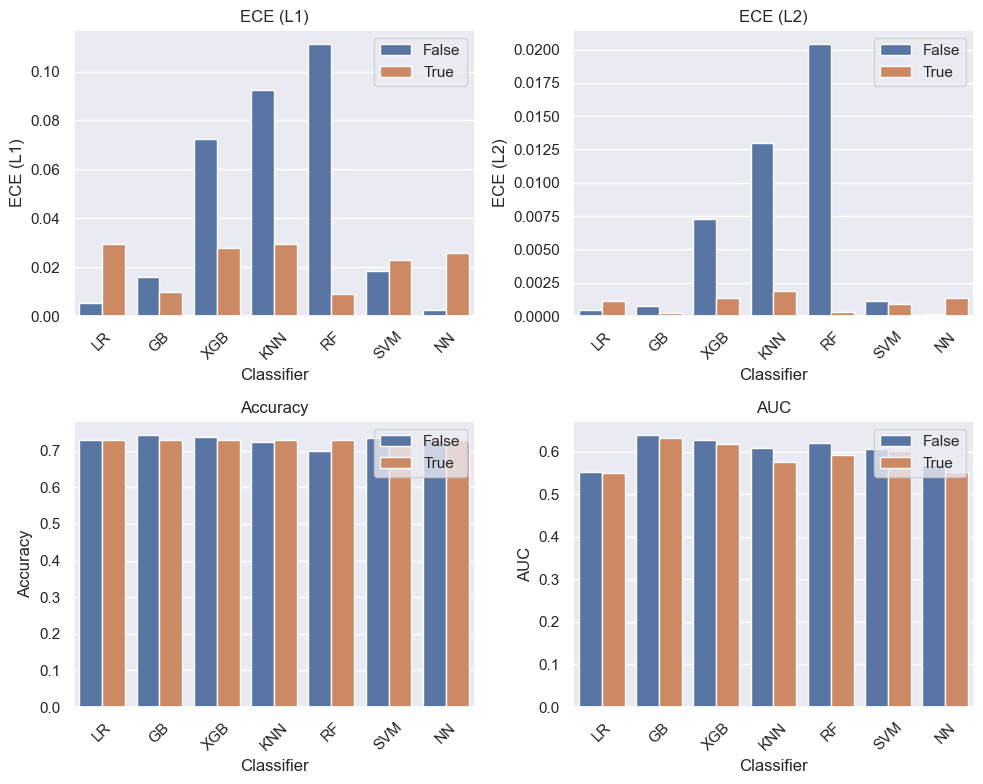

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
metrics = ['ece_l1', 'ece_l2', 'accuracy', 'auc']
titles = ['ECE (L1)', 'ECE (L2)', 'Accuracy', 'AUC']
axes = axes.ravel()

# Create subplots
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=training_results_df,
        x='clf',
        y=metric,
        hue='calibrated',
        ax=axes[idx],
    )
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel(title)
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    # Move legend to a better position
    axes[idx].legend(title='')

# Adjust layout
plt.tight_layout()
plt.show()

### Section 2: Comparing Ski Rental Algorithms

In [133]:
CR_df = []
bins=100
num_runs = 5
conf = 0.8
thresh = 0.5
for i in range(num_runs):
    for b in [400, 500, 600, 700, 800, 900, 1000, 1200]:
    #for b in [5*60, 7*60, 10*60, 15*60]:#, 20*60, 25*60]: 
        print(b)
        results_df = pd.DataFrame()
        indices = np.arange(len(X))

        # First split: separate out test set (20% of data)
        idx_temp, idx_test = train_test_split(
            indices, test_size=0.20, random_state=i
        )

        # Second split: split remaining data into train and validation (0.25 = 20% of original 80%)
        idx_train, idx_valid = train_test_split(
            idx_temp, test_size=0.50, random_state=i
        )
        
        # regression 
        X_train = X_post_reg[idx_train]
        X_valid = X_post_reg[idx_valid]
        X_test = X_post_reg[idx_test]
        
        y_train = y[idx_train]
        y_valid = y[idx_valid]
        y_test = y[idx_test]
                        
        reg_model_name = md.get_best_regressor(X_train,
                                               y_train,
                                               X_valid,
                                               y_valid)
        
        model = Pipeline(
            [
                ("scalar", StandardScaler()),
                (reg_model_name, md.reg_dict[reg_model_name]())

            ]
        )
        rf = WrapRegressor(model)
        rf.fit(X_train, y_train)
        rf.calibrate(X_valid, y_valid)
        
        conf_interval = rf.predict_int(X_test, confidence=conf)
        results_df['reg_sgd_val'] = model.predict(X_test)
        results_df['reg_sgd_conf_low'] = np.maximum(conf_interval[:, 0], 1)
        results_df['reg_sgd_conf_high'] = conf_interval[:, 1]
        results_df['y'] = y_test 

        
        # classification: 
        X_train = X_post_clf[idx_train]
        X_valid = X_post_clf[idx_valid]
        X_test = X_post_clf[idx_test]
        
        y_train = y_train > b
        y_valid = y_valid > b
        y_test = y_test > b
        results_df['y_bin'] = y_test
        results_df['delta'] = 1 - conf
        
        # clf_model_name = md.get_best_classifier(X_train,
        #                                        y_train,
        #                                        X_valid,
        #                                        y_valid)
        clf_model_name = 'GB'
        curr_clf = md.model_choice(clf_model_name, X_train, y_train)
        curr_clf.fit(X_train, y_train)
    
        # get model score
        probs = curr_clf.predict_proba(X_test)[:, 1]
        valid_probs = curr_clf.predict_proba(X_valid)[:, 1]
        eps = 1 - curr_clf.score(X_valid, y_valid) 
        results_df['eps'] = eps
        
        # get opt threshold: 
        fpr, tpr, thresholds = roc_curve(y_valid, valid_probs)
        j_scores = tpr - fpr
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        
        calibrator = cal.BinningCalibrator(bins=bins)
        calibrator.calibrate(y_prob=curr_clf.predict_proba(X_valid)[:, 1], 
                             y_true=y_valid, 
                            subsample=True)
        
        y_cal_probs = calibrator.transform(probs)
        
        valid_probs = calibrator.transform(curr_clf.predict_proba(X_valid)[:, 1])
        _, _, _, _, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_valid),
                                             prob_pred=np.asarray(valid_probs),
                                             num_bins=bins, 
                                             subsample=True)
    
        results_df['clf_pred'] =  curr_clf.predict_proba(X_test)[:, 1] > optimal_threshold
        results_df['clf_prob'] = y_cal_probs
        results_df['alpha'] = alpha
        results_df['b'] = b
        
        results_df['pip_day'] = results_df.apply(
            lambda row: sr.pip_alg(
                u=row['reg_sgd_conf_high'],
                l=row['reg_sgd_conf_high'], 
                delta=row['delta'],
                b=row['b']
            ), 
            axis=1
        )

        results_df['bin_day'] = results_df.apply(
            lambda row: sr.regular_ski_rental(pred=row['clf_pred'],
                                           eps=row['eps'],
                                           b=row['b'], 
            ), 
            axis=1
        )

        results_df['breakeven_day'] = b

        results_df['cal_day'] = results_df.apply(
            lambda row: sr.cal_ski_rental(pred=row['clf_prob'],
                                           alpha=row['alpha'],
                                           b=row['b'], 
            ), 
            axis=1
        )
        results_df['pip_CR'] = results_df.apply(
            lambda row: sr.get_CR(
                buy=row['pip_day'],
                y=row['y'],
                b=row['b']
            ), 
            axis=1
        )

        results_df['bin_CR'] = results_df.apply(
            lambda row: sr.get_CR(
                buy=row['bin_day'],
                y=row['y'],
                b=row['b']
            ), 
            axis=1
        )

        results_df['breakeven_CR'] = results_df.apply(
            lambda row: sr.get_CR(
                buy=row['breakeven_day'],
                y=row['y'],
                b=row['b']
            ), 
            axis=1
        )

        results_df['cal_CR'] = results_df.apply(
            lambda row: sr.get_CR(
                buy=row['cal_day'],
                y=row['y'],
                b=row['b']
            ), 
            axis=1
        )
        # results_df['worse'] = results_df['cal_CR'] > results_df['bin_CR']
        # results_df['better'] = results_df['cal_CR'] < results_df['bin_CR']
        # print(f"cal worse than bin {results_df['worse'].sum()} cal better than bin {results_df['better'].sum()}")
        CR_summary = results_df[['cal_CR', 'bin_CR','pip_CR', 'breakeven_CR']].mean().to_dict() 
        # CR_summary['cal CR > bin CR'] = results_df['worse'].sum()
        # CR_summary['bin CR > cal CR'] = results_df['better'].sum()
        CR_summary['b'] = b
        CR_summary['i'] = i
        CR_summary['opt_thresh'] = optimal_threshold
        CR_df.append(CR_summary)

400
best regressor score: XGBR 0.15643811225891113
new len: 80038
new len: 80038
500
best regressor score: XGBR 0.15643811225891113
new len: 110744
new len: 110744
600
best regressor score: XGBR 0.15643811225891113
new len: 84466
new len: 84466
700
best regressor score: XGBR 0.15643811225891113
new len: 64558
new len: 64558
800
best regressor score: XGBR 0.15643811225891113
new len: 49626
new len: 49626
900
best regressor score: XGBR 0.15643811225891113
new len: 38488
new len: 38488
1000
best regressor score: XGBR 0.15643811225891113
new len: 30058
new len: 30058
1200
best regressor score: XGBR 0.15643811225891113
new len: 19034
new len: 19034
400
best regressor score: XGBR 0.1496453881263733
new len: 80006
new len: 80006
500
best regressor score: XGBR 0.1496453881263733
new len: 110726
new len: 110726
600
best regressor score: XGBR 0.1496453881263733
new len: 84166
new len: 84166
700
best regressor score: XGBR 0.1496453881263733
new len: 64008
new len: 64008
800
best regressor score: 

In [129]:
CR_df = pd.DataFrame(CR_df)

In [132]:
CR_df

,cal_CR,bin_CR,pip_CR,breakeven_CR,b,i,opt_thresh
0,1.368273,1.413695,1.662731,1.379040,600,0,0.388242
1,1.215072,1.310378,1.608978,1.221723,800,0,0.227420
2,1.135306,1.290103,1.247209,1.134112,1000,0,0.136069
3,1.090865,1.322443,1.104552,1.084621,1200,0,0.080594
4,1.370622,1.411956,1.665881,1.380240,600,1,0.390065
5,1.216464,1.329883,1.603330,1.224355,800,1,0.217954
6,1.135275,1.301915,1.242994,1.137657,1000,1,0.129507
7,1.090545,1.328676,1.105625,1.085928,1200,1,0.079017
8,1.365038,1.419113,1.660411,1.374707,600,2,0.379325
9,1.213195,1.332549,1.603999,1.219592,800,2,0.217042


In [130]:
CR_df.groupby('b').mean()

,cal_CR,bin_CR,pip_CR,breakeven_CR,i,opt_thresh
b,,,,,,
600,1.368599,1.413436,1.661561,1.378202,2.0,0.385432
800,1.214974,1.320412,1.604598,1.221723,2.0,0.223134
1000,1.134157,1.284583,1.242196,1.134549,2.0,0.135812
1200,1.089911,1.322636,1.104116,1.084861,2.0,0.081053


Text(0, 0.5, 'CR')

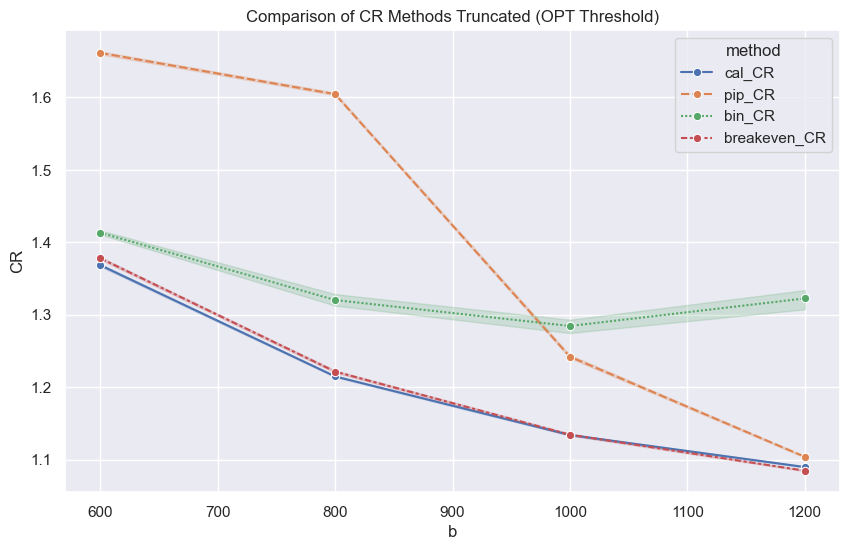

In [131]:
# Melt the DataFrame
melted_df = pd.melt(CR_df, 
                    # Keep b and i as id variables
                    id_vars=['b', 'i'],
                    # Select the CR columns to melt
                    value_vars=['cal_CR', 'pip_CR', 'bin_CR', 'breakeven_CR'],
                    # Name the new columns
                    var_name='method',
                    value_name='CR')

# Now you can plot using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Create the line plot with confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df,
             x='b',
             y='CR',
             hue='method',
             style='method',
             marker='o')  # This will add 95% confidence intervals

plt.title('Comparison of CR Methods Truncated (OPT Threshold)')
plt.xlabel('b')
plt.ylabel('CR')

## Debugging 

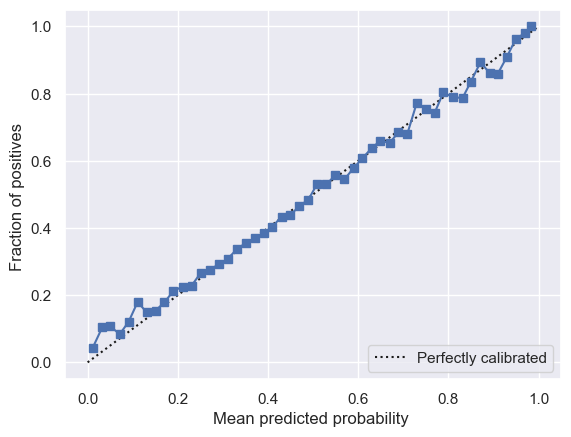

In [92]:
# display calibration 
from sklearn.calibration import calibration_curve, CalibrationDisplay
y_prob = curr_clf.predict_proba(X_valid)[:, 1]
prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=50)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

new len: 80680


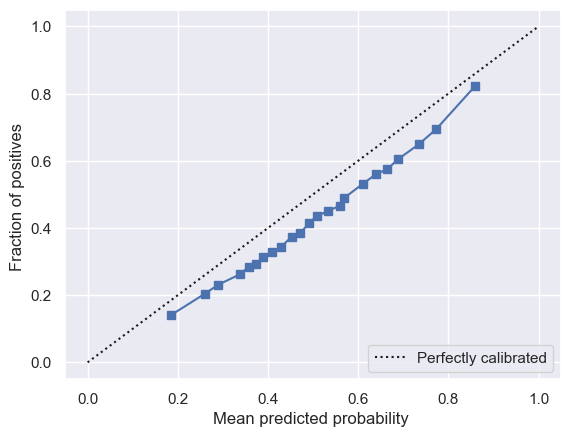

In [94]:
y_prob = curr_clf.predict_proba(X_valid)[:, 1]
calibrator = cal.HistogramCalibrator(bins=50)
calibrator.calibrate(y_prob=y_prob, 
                     y_true=y_valid, subsample=True)
cal_valid_probs = calibrator.transform(y_prob)
        
prob_true, prob_pred = calibration_curve(y_valid, cal_valid_probs, n_bins=50)
disp = CalibrationDisplay(prob_true, prob_pred, cal_valid_probs)
disp.plot()

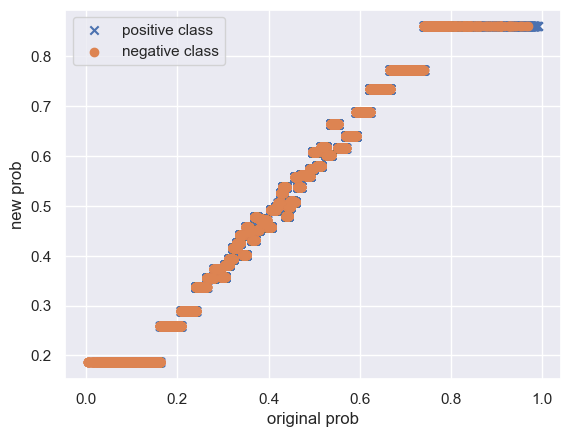

In [95]:
mask = y_valid == 1 
plt.scatter(y_prob[mask], cal_valid_probs[mask], marker='x', label='positive class')
plt.scatter(y_prob[~mask], cal_valid_probs[~mask], marker='o', label='negative class')
plt.xlabel("original prob")
plt.ylabel("new prob")
plt.legend()

In [114]:
b = 600
i = 2 
bins = 20
results_df = pd.DataFrame()
indices = np.arange(len(X))

# First split: separate out test set (20% of data)
idx_temp, idx_test = train_test_split(
    indices, test_size=0.20, random_state=i
)

# Second split: split remaining data into train and validation (0.25 = 20% of original 80%)
idx_train, idx_valid = train_test_split(
    idx_temp, test_size=0.50, random_state=i
)

# regression 
X_train = X_post_reg[idx_train]
X_valid = X_post_reg[idx_valid]
X_test = X_post_reg[idx_test]

y_train = y[idx_train]
y_valid = y[idx_valid]
y_test = y[idx_test]

reg_model_name = md.get_best_regressor(X_train,
                                       y_train,
                                       X_valid,
                                       y_valid)

model = Pipeline(
    [
        ("scalar", StandardScaler()),
        (reg_model_name, md.reg_dict[reg_model_name]())

    ]
)
rf = WrapRegressor(model)
rf.fit(X_train, y_train)
rf.calibrate(X_valid, y_valid)
conf = 0.9

conf_interval = rf.predict_int(X_test, confidence=conf)
results_df['reg_sgd_val'] = model.predict(X_test)
results_df['reg_sgd_conf_low'] = np.maximum(conf_interval[:, 0], 1)
results_df['reg_sgd_conf_high'] = conf_interval[:, 1]
results_df['y'] = y_test 


# classification: 
X_train = X_post_clf[idx_train]
X_valid = X_post_clf[idx_valid]
X_test = X_post_clf[idx_test]

y_train = y_train > b
y_valid = y_valid > b
y_test = y_test > b
results_df['y_bin'] = y_test
results_df['delta'] = 1 - conf 

# clf_model_name = md.get_best_classifier(X_train,
#                                        y_train,
#                                        X_valid,
#                                        y_valid)
clf_model_name ='XGB'
curr_clf = md.model_choice(clf_model_name, X_train, y_train)
curr_clf.fit(X_train, y_train)
eps = 1 - curr_clf.score(X_valid, y_valid) 
results_df['eps'] = eps

probs = curr_clf.predict_proba(X_test)[:, 1]
calibrator = cal.BinningCalibrator(bins=bins)
calibrator.calibrate(y_prob=curr_clf.predict_proba(X_valid)[:, 1], 
                     y_true=y_valid, 
                    subsample=True)

y_cal_probs = calibrator.transform(probs)

valid_probs = calibrator.transform(curr_clf.predict_proba(X_valid)[:, 1])
_, _, _, _, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_valid),
                                     prob_pred=np.asarray(valid_probs),
                                     num_bins=bins, 
                                     subsample=True)

print(f"calibration error new: {alpha}")
results_df['clf_pred'] =  curr_clf.predict_proba(X_test)[:, 1] > 0.9
results_df['clf_prob'] = y_cal_probs
results_df['alpha'] = alpha
results_df['b'] = b

        
results_df['pip_day'] = results_df.apply(
    lambda row: sr.pip_alg(
        u=row['reg_sgd_conf_high'],
        l=row['reg_sgd_conf_high'], 
        delta=row['delta'],
        b=row['b']
    ), 
    axis=1
)

results_df['bin_day'] = results_df.apply(
    lambda row: sr.regular_ski_rental(pred=row['clf_pred'],
                                   eps=row['eps'],
                                   b=row['b'], 
    ), 
    axis=1
)

results_df['breakeven_day'] = b

results_df['cal_day'] = results_df.apply(
    lambda row: sr.cal_ski_rental(pred=row['clf_prob'],
                                   alpha=row['alpha'],
                                   b=row['b'], 
    ), 
    axis=1
)
results_df['pip_CR'] = results_df.apply(
    lambda row: sr.get_CR(
        buy=row['pip_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df['bin_CR'] = results_df.apply(
    lambda row: sr.get_CR(
        buy=row['bin_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df['breakeven_CR'] = results_df.apply(
    lambda row: sr.get_CR(
        buy=row['breakeven_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df['cal_CR'] = results_df.apply(
    lambda row: sr.get_CR(
        buy=row['cal_day'],
        y=row['y'],
        b=row['b']
    ), 
    axis=1
)

results_df[['cal_CR', 'pip_CR','bin_CR', 'breakeven_CR']].mean()

best regressor score: XGBR 0.0830615758895874
new len: 8074
new len: 8074
calibration error new: 0.00113627988108983


cal_CR          1.956525
pip_CR          1.338450
bin_CR          1.246336
breakeven_CR    1.956525
dtype: float64

In [116]:
np.unique(y_cal_probs, return_counts=True), np.unique(probs, return_counts=True)

((array([0.13861386, 0.28465347, 0.31930693, 0.39356436, 0.41089109,
         0.43811881, 0.45792079, 0.48514851, 0.51732673, 0.52722772,
         0.53465347, 0.5470297 , 0.5483871 , 0.5519802 , 0.56435644,
         0.59801489, 0.60049628, 0.65260546, 0.66253102, 0.76923077]),
  array([ 897, 1607, 1703, 2084, 1961, 2291, 2153, 2443, 2276, 2742, 2531,
         2434, 2916, 2550, 2676, 2874, 2710, 2898, 3035, 3546])),
 (array([0.07985057, 0.10163471, 0.10578175, ..., 0.99975294, 0.9997874 ,
         0.9998153 ], shape=(22009,), dtype=float32),
  array([1, 1, 1, ..., 1, 1, 1], shape=(22009,))))

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = curr_clf.predict_proba(X_test)[:, 1] > 0.9
confusion_matrix(y_test, y_pred)

In [ ]:
results_df[['clf_pred',  'y_bin']].value_counts()

In [ ]:
results_df[['clf_pred',  'y_bin', 'bin_CR']].value_counts()

In [ ]:
# validate naive algorithm
results_df[['clf_pred',  'y_bin', 'bin_day', 'bin_CR', 'y']].value_counts()

In [ ]:
results_df['worse'] = results_df['cal_CR'] > results_df['bin_CR']
results_df['better'] = results_df['cal_CR'] < results_df['bin_CR']

In [ ]:
print("alpha", results_df['alpha'].value_counts())
print("alpha threshold", (4 + 3 * alpha) / 5)
worst_df = results_df[results_df['worse'] == True]
print("competitive ratio total diff: ", (worst_df['cal_CR']-worst_df['bin_CR']).sum())
print("cal worse than bin for : ", len(worst_df))
worst_df.groupby(['clf_pred', 'y_bin', 'clf_prob', 'bin_CR', 'cal_CR', 'cal_day']).count()

In [ ]:
better_df = results_df[results_df['better'] == True]
print("competitive ratio total diff: ", (better_df['bin_CR']-better_df['cal_CR']).sum())
print("cal better than bin for : ", len(better_df))
better_df.groupby(['clf_pred', 'y_bin', 'clf_prob', 'bin_CR', 'cal_CR', 'cal_day']).count()

In [ ]:
print("delta", results_df['delta'].value_counts())
results_df.groupby(['clf_pred', 'y_bin', 'pip_CR', 'pip_day'])['y'].count()